In [63]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [64]:
sys.path.append('../../fastai/')

In [65]:
from fastai.structured import *
from fastai.column_data import *

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [18]:
def col_nunique(df): return {c: df[c].nunique() for c in df.columns} # get number of unique elements
def col_nas(df): return ({c:df[c].isnull().sum() for c in df.columns}) # get number of NAs

In [29]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [30]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [20]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [46]:
train.drop('id', inplace=True, axis=1)

In [47]:
train.shape, test.shape

((43400, 11), (18601, 11))

In [48]:
train.stroke.mean()

0.01804147465437788

In [49]:
col_nunique(train)

{'Residence_type': 2,
 'age': 104,
 'avg_glucose_level': 12543,
 'bmi': 555,
 'ever_married': 2,
 'gender': 3,
 'heart_disease': 2,
 'hypertension': 2,
 'smoking_status': 3,
 'stroke': 2,
 'work_type': 5}

In [50]:
col_nas(train)

{'Residence_type': 0,
 'age': 0,
 'avg_glucose_level': 0,
 'bmi': 1462,
 'ever_married': 0,
 'gender': 0,
 'heart_disease': 0,
 'hypertension': 0,
 'smoking_status': 13292,
 'stroke': 0,
 'work_type': 0}

In [51]:
col_nas(test)

{'Residence_type': 0,
 'age': 0,
 'avg_glucose_level': 0,
 'bmi': 591,
 'ever_married': 0,
 'gender': 0,
 'heart_disease': 0,
 'hypertension': 0,
 'id': 0,
 'smoking_status': 5751,
 'work_type': 0}

### Train-Val

In [114]:
sshuffle = StratifiedKFold(5, random_state=42)

In [115]:
train.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


In [116]:
train.dtypes

gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke               category
dtype: object

In [ ]:
# convert object to category
train_cats(train)

In [150]:
train_cats(test)

In [167]:
# numerical encoding for cats
df, y, nas = proc_df(train, 'stroke')
test_df,_,nas = proc_df(test, na_dict=nas)
test_df.drop('id', 1, inplace=True)

In [170]:
cv_idxs = list(sshuffle.split(df,y))

In [171]:
# original ratio
train.stroke.cat.codes.mean()

0.01804147465437788

### Random Forest Baseline

In [190]:
set_rf_samples(20000)
reset_rf_samples()

In [184]:
rf = RandomForestClassifier(n_estimators=40, n_jobs=-1, criterion='gini',
                  max_depth=5, min_samples_leaf=1, oob_score=True)

In [185]:
rf.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [186]:
rf.oob_score_

0.9819585253456221

In [187]:
df.index

RangeIndex(start=0, stop=43400, step=1)

In [208]:
def train_and_eval(df=df, cv_idxs=cv_idxs, rf=rf):
    """evaluate auc cv score"""
    scores = []
    for trn_idx, val_idx in cv_idxs:
        trn_df, val_df = df.iloc[trn_idx], df.iloc[val_idx]
        trn_y, val_y = y[trn_idx], y[val_idx]
        rf.fit(trn_df, trn_y) # fit model
        val_preds = rf.predict_proba(val_df)[:,1]
        score = roc_auc_score(val_y, val_preds)
        scores.append(score)
    return scores

In [196]:
params = {
    'n_estimators': range(40,100,10),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,5,10,30],
    'n_jobs': [-1]
}

In [199]:
from itertools import product
param_grids = [dict(zip(params, v)) for v in product(*params.values())]

In [203]:
# select random params
n_random = 50
random_param_grids = np.random.choice(param_grids, size=n_random, replace=False)

In [206]:
verbose = True
init_score = 0
for param_grid in random_param_grids:
    rf = RandomForestClassifier(**param_grid)
    scores = np.array(train_and_eval(df, cv_idxs, rf))
    scores_mean, scores_std = scores.mean(), scores.std()
    if scores.mean() > init_score:
        init_score = scores_mean
        best_params = param_grid
    if verbose:
        print(param_grid)
        print(scores_mean, scores_std)

{'n_estimators': 40, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8536829373412097 0.011617081355706238
{'n_estimators': 40, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8534457444999415 0.007432147961322747
{'n_estimators': 60, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8335614563320851 0.011518883797717105
{'n_estimators': 50, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8295489236628489 0.011785995321650483
{'n_estimators': 60, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_jobs': -1}
0.753630351546251 0.01489740775245296
{'n_estimators': 50, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8539508965324192 0.008970425415919152
{'n_estimators': 40, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8321918533694109 0.01389619853

In [216]:
best_params, init_score

({'criterion': 'entropy',
  'max_features': 'sqrt',
  'min_samples_leaf': 30,
  'n_estimators': 50,
  'n_jobs': -1},
 0.8572504966268373)

In [224]:
models = {}

In [210]:
rf = RandomForestClassifier(**best_params)

In [211]:
rf.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [225]:
models['rf_baseline'] = rf

In [213]:
test_preds = rf.predict_proba(test_df)[:, 1]
submit_df = pd.DataFrame({"id": test.id, "stroke":test_preds})
test_preds

In [223]:
submit_df.to_csv("rf_baseline.csv", index=False)

### rfpimp

In [254]:
rf_feat_importance(rf, df)

,cols,imp
1,age,0.413463
7,avg_glucose_level,0.156397
8,bmi,0.124178
10,bmi_na,0.067259
3,heart_disease,0.051590
5,work_type,0.041593
9,smoking_status,0.039872
4,ever_married,0.039700
2,hypertension,0.030800
6,Residence_type,0.018915


In [230]:
import rfpimp

In [231]:
def permutation_importances_raw(rf, X_train, y_train, metric):
    """
    Return array of importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    X_train = X_train.copy(deep=False) # shallow copy
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [239]:
def auc_metric(rf, X_train, y_train):
    pred_proba = rf.predict_proba(X_train)[:, 1]
    return roc_auc_score(y_train, pred_proba)

In [240]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_na
0,2,3.0,0,0,1,5,1,95.12,18.0,0,False
1,2,58.0,1,0,2,3,2,87.96,39.2,2,False
2,1,8.0,0,0,1,3,2,110.89,17.6,0,False
3,1,70.0,0,0,2,3,1,69.04,35.9,1,False
4,2,14.0,0,0,1,2,1,161.28,19.1,0,False


In [242]:
importances = permutation_importances_raw(rf, df, y, auc_metric)

In [247]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'bmi_na'],
      dtype='object')

In [256]:
imp_df = pd.DataFrame({"Feature": df.columns, "Importance": importances}).\
    set_index('Feature').sort_values('Importance')
rfpimp.plot_importances(imp_df)

### Random Forest Dropcols

In [261]:
df_reduced = df[['age', 'avg_glucose_level', 'bmi']]

In [262]:
set_rf_samples(20000)
reset_rf_samples()

In [263]:
params = {
    'n_estimators': range(40,100,10),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,5,10,30],
    'n_jobs': [-1]
}

In [264]:
param_grids = [dict(zip(params, v)) for v in product(*params.values())]

In [266]:
n_random = 50
random_param_grids = np.random.choice(param_grids, size=n_random, replace=False)

In [267]:
verbose = True
init_score = 0

for param_grid in random_param_grids:
    rf = RandomForestClassifier(**param_grid)
    scores = np.array(train_and_eval(df_reduced, cv_idxs, rf))
    scores_mean, scores_std = scores.mean(), scores.std()
    if scores.mean() > init_score:
        init_score = scores_mean
        best_params = param_grid
    if verbose:
        print(param_grid)
        print(scores_mean, scores_std)

{'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8085763484723412 0.009837628295821887
{'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8408433376262522 0.006808705469828797
{'n_estimators': 60, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8115318635443038 0.009610407762825852
{'n_estimators': 60, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 10, 'n_jobs': -1}
0.8245661828859058 0.005838485219594475
{'n_estimators': 60, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8072363493829025 0.009047274549523992
{'n_estimators': 60, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'n_jobs': -1}
0.7122376516011817 0.021115720763079496
{'n_estimators': 80, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8396880726982079 0.011

In [268]:
best_params, init_score

({'criterion': 'entropy',
  'max_features': 'log2',
  'min_samples_leaf': 30,
  'n_estimators': 60,
  'n_jobs': -1},
 0.8420725076302441)

In [269]:
rf = RandomForestClassifier(**best_params)

In [275]:
rf.fit(df_reduced, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [276]:
models['rf_reduced'] = rf

In [277]:
test_reduced = test_df[['age', 'avg_glucose_level', 'bmi']]

In [278]:
test_preds = rf.predict_proba(test_reduced)[:, 1]
submit_df = pd.DataFrame({"id": test.id, "stroke":test_preds})
test_preds

array([0.07638, 0.04494, 0.     , ..., 0.13445, 0.00284, 0.00395])

(array([14050.,  1893.,  1120.,   751.,   409.,   208.,   105.,    41.,    19.,     5.]),
 array([0.   , 0.022, 0.044, 0.066, 0.088, 0.11 , 0.132, 0.154, 0.176, 0.198, 0.22 ]),
 <a list of 10 Patch objects>)

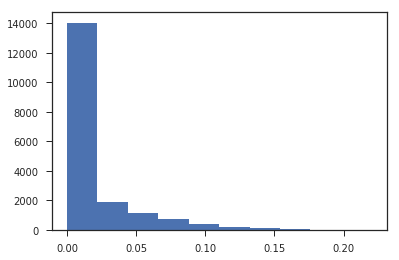

In [279]:
plt.hist(test_preds)

In [280]:
submit_df.to_csv("rf_reduced.csv", index=False)

In [281]:
submit_df.head()

,id,stroke
0,36306,0.076383
1,61829,0.044942
2,14152,0.000000
3,12997,0.000000
4,40801,0.036141


### Tets set sample

Full columns perform better

In [282]:
set_rf_samples(20000)
reset_rf_samples()

In [ ]:
best_params, best_score = ({'criterion': 'entropy',
  'max_features': 'sqrt',
  'min_samples_leaf': 30,
  'n_estimators': 50,
  'n_jobs': -1},
 0.8572504966268373)

In [283]:
rf = RandomForestClassifier(**best_params)

In [313]:
best_score = 0
for sample_sz in range(10000, 50000, 10000):
    set_rf_samples(sample_sz)
    scores = train_and_eval(df, cv_idxs, rf)
    score = np.array(scores).mean()
    if score > best_score:
        best_score = score
    print(sample_sz, score)

10000 0.8588483589555158
20000 0.8566037952285063
30000 0.857225813482543
40000 0.8565859836525108


In [288]:
set_rf_samples(10000)
rf = RandomForestClassifier(**best_params)

In [289]:
rf.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [292]:
test_preds = rf.predict_proba(test_df)[:, 1]
submit_df = pd.DataFrame({"id": test.id, "stroke":test_preds})
test_preds

array([0.08657, 0.10064, 0.00059, ..., 0.09457, 0.01315, 0.0029 ])

In [293]:
submit_df.to_csv("rf_set_sample.csv", index=False)

(array([13512.,  2073.,   972.,   800.,   661.,   328.,   131.,    72.,    43.,     9.]),
 array([0.     , 0.01858, 0.03715, 0.05573, 0.07431, 0.09289, 0.11146, 0.13004, 0.14862, 0.1672 , 0.18577]),
 <a list of 10 Patch objects>)

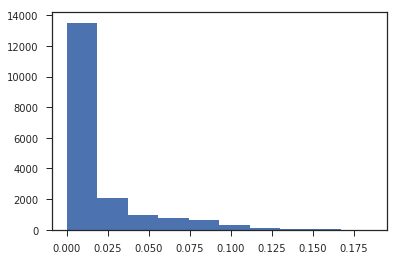

In [294]:
plt.hist(test_preds)

In [298]:
pd.cut(test_preds, bins=3)

[(0.0619, 0.124], (0.0619, 0.124], (-0.000186, 0.0619], (-0.000186, 0.0619], (-0.000186, 0.0619], ..., (-0.000186, 0.0619], (-0.000186, 0.0619], (0.0619, 0.124], (-0.000186, 0.0619], (-0.000186, 0.0619]]
Length: 18601
Categories (3, object): [(-0.000186, 0.0619] < (0.0619, 0.124] < (0.124, 0.186]]

In [302]:
y.mean()

0.01804147465437788

In [305]:
percentile = np.percentile(test_preds, 100*(1 - y.mean()))

In [306]:
percentile

0.10462696095587505

In [308]:
test_preds[test_preds > percentile] = 0.95

In [309]:
submit_df = pd.DataFrame({"id": test.id, "stroke":test_preds})
submit_df.to_csv("rf_set_sample_pushed_preds.csv", index=False)

### Binning

age and bmi

In [315]:
best_score

0.8588483589555158

(array([3932., 3134., 3989., 4306., 4988., 5155., 5528., 4738., 3499., 4131.]),
 array([ 0.08 ,  8.272, 16.464, 24.656, 32.848, 41.04 , 49.232, 57.424, 65.616, 73.808, 82.   ]),
 <a list of 10 Patch objects>)

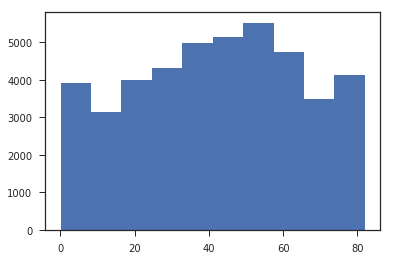

In [310]:
plt.hist(df.age)

(array([ 3625., 16815., 16856.,  4745.,  1063.,   241.,    40.,     6.,     4.,     5.]),
 array([10.1 , 18.85, 27.6 , 36.35, 45.1 , 53.85, 62.6 , 71.35, 80.1 , 88.85, 97.6 ]),
 <a list of 10 Patch objects>)

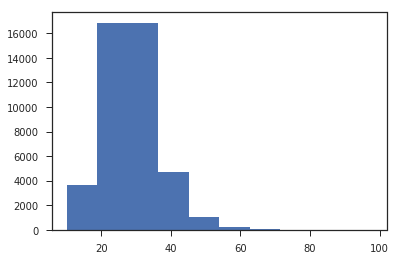

In [327]:
plt.hist(df.bmi)

In [324]:
df['age_bins'] = pd.cut(df.age, range(0, 100, 10)).cat.codes
df['bmi_bins'] = pd.cut(df.bmi, range(0, 100, 5)).cat.codes

In [349]:
test_df['age_bins'] = pd.cut(test_df.age, range(0, 100, 10)).cat.codes
test_df['bmi_bins'] = pd.cut(test_df.bmi, range(0, 100, 5)).cat.codes

In [334]:
train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [335]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_na,age_bins,bmi_bins
0,2,3.0,0,0,1,5,1,95.12,18.0,0,False,0,3
1,2,58.0,1,0,2,3,2,87.96,39.2,2,False,5,7
2,1,8.0,0,0,1,3,2,110.89,17.6,0,False,0,3
3,1,70.0,0,0,2,3,1,69.04,35.9,1,False,6,7
4,2,14.0,0,0,1,2,1,161.28,19.1,0,False,1,3


In [339]:
n_random = 60
random_param_grids = np.random.choice(param_grids, size=n_random, replace=False)

In [340]:
reset_rf_samples()

In [341]:
verbose = True
init_score = 0

for param_grid in random_param_grids:
    rf = RandomForestClassifier(**param_grid)
    scores = np.array(train_and_eval(df, cv_idxs, rf))
    scores_mean, scores_std = scores.mean(), scores.std()
    if scores.mean() > init_score:
        init_score = scores_mean
        best_params = param_grid
    if verbose:
        print(param_grid)
        print(scores_mean, scores_std)

{'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8329733457777382 0.007516492190156628
{'n_estimators': 60, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8355271022886365 0.008590525120304292
{'n_estimators': 60, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8569076539675595 0.00994684309953329
{'n_estimators': 70, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8565687042325397 0.007175519256760008
{'n_estimators': 40, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_jobs': -1}
0.748058763242229 0.017637056391820633
{'n_estimators': 50, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_jobs': -1}
0.8321387356378349 0.010229922835435676
{'n_estimators': 80, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8560821151158733 0.01038

{'n_estimators': 40, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_jobs': -1}
0.7406245918003984 0.009558125313461528
{'n_estimators': 80, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_jobs': -1}
0.8493540178188794 0.007799032879184625
{'n_estimators': 90, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_jobs': -1}
0.8597820152490947 0.009532497173487935
{'n_estimators': 90, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 10, 'n_jobs': -1}
0.8477827542941665 0.008946895477664911


In [342]:
best_params, init_score

({'criterion': 'gini',
  'max_features': 'sqrt',
  'min_samples_leaf': 30,
  'n_estimators': 90,
  'n_jobs': -1},
 0.8597820152490947)

In [343]:
rf = RandomForestClassifier(**best_params)

In [354]:
scores = np.array(train_and_eval(df, cv_idxs, rf))
scores.mean(), scores.std()

(0.8573862509838678, 0.00798285552956845)

In [345]:
rf.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [346]:
importances = permutation_importances_raw(rf, df, y, auc_metric)

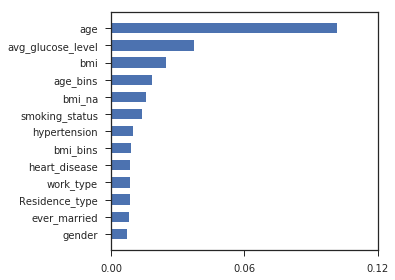

In [347]:
imp_df = pd.DataFrame({"Feature": df.columns, "Importance": importances}).\
    set_index('Feature').sort_values('Importance')
rfpimp.plot_importances(imp_df)

In [350]:
test_preds = rf.predict_proba(test_df)[:, 1]
submit_df = pd.DataFrame({"id": test.id, "stroke":test_preds})
test_preds

array([0.05793, 0.09284, 0.00009, ..., 0.08084, 0.00833, 0.00327])

In [351]:
submit_df.to_csv("rf_with_bins.csv", index=False)

### XGBOOST

In [373]:
import xgboost as xgb

In [378]:
# numerical encoding for cats
df, y, nas = proc_df(train, 'stroke')
test_df,_,nas = proc_df(test, na_dict=nas)
test_df.drop('id', 1, inplace=True)

In [379]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,bmi_na
0,2,3.0,0,0,1,5,1,95.12,18.0,0,False
1,2,58.0,1,0,2,3,2,87.96,39.2,2,False
2,1,8.0,0,0,1,3,2,110.89,17.6,0,False
3,1,70.0,0,0,2,3,1,69.04,35.9,1,False
4,2,14.0,0,0,1,2,1,161.28,19.1,0,False


In [380]:
trn_idx, val_idx = cv_idxs[0]

trn_df = df.iloc[trn_idx] 
trn_y = y[trn_idx]
val_df = df.iloc[val_idx]
val_y = y[val_idx]

In [382]:
dtrain = xgb.DMatrix(trn_df, trn_y)
dval = xgb.DMatrix(val_df, val_y)

In [385]:
params = {}

In [410]:
params['objective'] = 'binary:logistic'
params['eta'] = 0.001 #tradeoff with num_boost_round

# model complexity
params['max_depth'] = 5
params['min_child_weight'] = 1
params['gamma'] = 1
# noise and variance
params['subsample'] = 1
params['colsample_bytree'] = 1
params['colsample_bylevel'] = 1
params['seed'] = 20
params['eval_metric'] = 'auc'

In [411]:
evals = [(dtrain, 'train'), (dval, 'valid')]

In [412]:
model = xgb.train(params=params, dtrain=dtrain,evals=evals, maximize=True,
                  num_boost_round=10000,  early_stopping_rounds=200, verbose_eval=20)

[0]	train-auc:0.839343	valid-auc:0.814743
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[20]	train-auc:0.83941	valid-auc:0.81481
[40]	train-auc:0.840695	valid-auc:0.815081
[60]	train-auc:0.840717	valid-auc:0.815093
[80]	train-auc:0.840984	valid-auc:0.81547
[100]	train-auc:0.841847	valid-auc:0.817158
[120]	train-auc:0.841846	valid-auc:0.817188
[140]	train-auc:0.8419	valid-auc:0.817314
[160]	train-auc:0.842571	valid-auc:0.818108
[180]	train-auc:0.842662	valid-auc:0.818137
[200]	train-auc:0.852395	valid-auc:0.830687
[220]	train-auc:0.853188	valid-auc:0.830637
[240]	train-auc:0.853519	valid-auc:0.831031
[260]	train-auc:0.853832	valid-auc:0.831159
[280]	train-auc:0.854469	valid-auc:0.831289
[300]	train-auc:0.854541	valid-auc:0.831587
[320]	train-auc:0.854557	valid-auc:0.831615
[340]	train-auc:0.8547	valid-auc:0.831573
[360]	train-auc:0.854733	valid-auc:0.831568
[380]	train-auc:0.854936	valid-au

In [403]:
model.best_score, model.best_iteration

(0.85617, 2201)

In [432]:
params['objective'] = 'binary:logistic'
params['eta'] = 0.01 #tradeoff with num_boost_round

# model complexity
params['max_depth'] = 5
params['min_child_weight'] = 1
params['gamma'] = 1
# noise and variance
params['subsample'] = 1
params['colsample_bytree'] = 1
params['colsample_bylevel'] = 1
params['seed'] = 20
params['eval_metric'] = 'auc'

params = {
    'objective': ['binary:logistic'],
    'eta': [0.01],
    'max_depth': range(3,10,1),
    'min_child_weight': [1,3,5,10,30],
    'gamma': [1,10,20,100],
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'colsample_bylevel': np.linspace(0.5, 1, 6),
    'seed': [20],
    'eval_metric': ['auc']
    
}

In [433]:
param_grids = [dict(zip(params, v)) for v in product(*params.values())]

In [434]:
# pick 100 random param grids
n_random = 100
random_param_grids = np.random.choice(param_grids, size=n_random, replace=False)

In [435]:
len(param_grids)

30240

In [436]:
best_round = 22002

In [437]:
model.best_score, model.best_iteration

(0.859545, 1160)

In [439]:
# create dtrain and dval for every cv pair
dtrain_dval_pairs = []
for trn_idx, val_idx in cv_idxs:
    trn_df = df.iloc[trn_idx] 
    trn_y = y[trn_idx]
    val_df = df.iloc[val_idx]
    val_y = y[val_idx]
    dtrain = xgb.DMatrix(trn_df, trn_y)
    dval = xgb.DMatrix(val_df, val_y)    
    dtrain_dval_pairs.append((dtrain, dval))

In [443]:
best_score = 0
best_params = None
best_iteration = None

for param_grid in param_grids:
    scores = []
    iterations = []
    for dtrain, dval in dtrain_dval_pairs: 
        
        evals = [(dtrain, 'train'), (dval, 'valid')]
        
        model = xgb.train(params=param_grid, dtrain=dtrain,evals=evals, maximize=True,
                      num_boost_round=best_round,  early_stopping_rounds=200, verbose_eval=False)

        model_cv_score, model_cv_iteration = model.best_score, model.best_iteration
        scores.append(model_cv_score)
        iterations.append(model_cv_iteration)
        print(model_cv_score)
    
    param_score, param_iteration = np.array(scores).mean(), np.array(iterations).mean()
    
    if param_score > best_score:
        best_score = param_score
        best_iteration = param_iterations
        best_params = param_grid

        print(best_params, best_score)

0.859545
0.856406
0.859197
0.85822
0.88587
{'objective': 'binary:logistic', 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'seed': 20, 'eval_metric': 'auc'} 0.8638475999999999
0.859288
0.855371
0.860534
0.859557
0.882263
0.859288
0.855371
0.860534
0.859557
0.882263
0.860163
0.857771
0.860918
0.860963
0.884774
{'objective': 'binary:logistic', 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 1, 'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'seed': 20, 'eval_metric': 'auc'} 0.8649178
0.860163
0.857771
0.860918
0.860963
0.884774
0.858985
0.856228
0.860639
0.860829
0.884518
0.859438
0.85702
0.860751
0.860119
0.883952
0.859438
0.85702
0.860751
0.860119
0.883952
0.859743
0.857186
0.860279
0.860582
0.884387
0.859743
0.857186
0.860279
0.860582
0.884387
0.860752
0.857882
0.860025
0.860774
0.885169
{'objective': 'binary:logistic', 'eta': 0.01, 'max_depth': 3, 'min_child_weight'

KeyboardInterrupt: 

### Final model

In [444]:
best_score, best_params, best_iteration 

(0.8649204000000001,
 {'colsample_bylevel': 0.9,
  'colsample_bytree': 0.6,
  'eta': 0.01,
  'eval_metric': 'auc',
  'gamma': 1,
  'max_depth': 3,
  'min_child_weight': 1,
  'objective': 'binary:logistic',
  'seed': 20,
  'subsample': 0.5},
 379.4)

In [445]:
dtrain = xgb.DMatrix(df, y)
dtest = xgb.DMatrix(test_df)

In [446]:
model = xgb.train(params=best_params, dtrain=dtrain,num_boost_round=int(best_iteration),verbose_eval=False)

In [448]:
test_preds = model.predict(dtest)

In [450]:
submit_df = pd.DataFrame({"id": test.id, "stroke":test_preds})
submit_df.to_csv("xgb.csv", index=False)